In [8]:
!pip install tensorflow

     ------------------------------------ 276.5/276.5 MB 226.1 kB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 286.3 kB/s eta 0:00:00
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached libclang-16.0.0-py2.py3-none-win_amd64.whl (24.4 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ------------------------------------ 440.8/440.8 kB 332.0 kB/s eta 0:00:00
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
^C


In [9]:
import os
import tqdm
import pathlib
import numpy as np
import pandas as pd
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\artda\\anaconda3\\Lib\\site-packages\\tensorflow\\compiler\\tf2tensorrt\\_pywrap_py_utils.pyd'
Consider using the `--user` option or check the permissions.



  Using cached tensorflow-2.13.0-cp310-cp310-win_amd64.whl (1.9 kB)
     ------------------------------------ 276.5/276.5 MB 548.7 kB/s eta 0:00:00
  Using cached tensorflow_estimator-2.13.0-py2.py3-none-any.whl (440 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached libclang-16.0.0-py2.py3-none-win_amd64.whl (24.4 MB)
  Using cached termcolor-2.3.0-py3-none-any.whl (6.9 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp310-cp310-win_amd64.whl (1.5 MB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

In [11]:
df = pd.read_csv('df_result_2.csv')
df.head()

,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_drug_NP,NumHDonors,NumHAcceptors,NumHeteroatoms,ExactMolWt,MaxAbsPartialCharge,...,NumAromaticHeterocycles,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,shape_spherical,shape_nanorods_and_triangles,shape_triangular,gram_p
0,4.0,10.0,8.0,17.0,32.0,4.0,6.0,9.0,365.104542,0.507967,...,0.0,48.0,84.0,120.0,37.0,2.0,1,0,0,0
1,4.0,10.0,8.0,17.0,32.0,1.0,5.0,8.0,372.054610,1.000000,...,0.0,48.0,84.0,120.0,37.0,2.0,1,0,0,0
2,15.0,30.0,28.0,17.0,32.0,4.0,6.0,9.0,365.104542,0.507967,...,0.0,48.0,84.0,120.0,37.0,2.0,1,0,0,0
3,15.0,30.0,28.0,17.0,32.0,1.0,5.0,8.0,372.054610,1.000000,...,0.0,48.0,84.0,120.0,37.0,2.0,1,0,0,0
4,5.0,30.0,21.0,0.0,17.0,19.0,25.0,35.0,1447.430200,0.507810,...,0.0,240.0,288.0,336.0,30.0,1.0,1,0,0,1


In [12]:
#df.drop('Unnamed: 0',axis = 1)

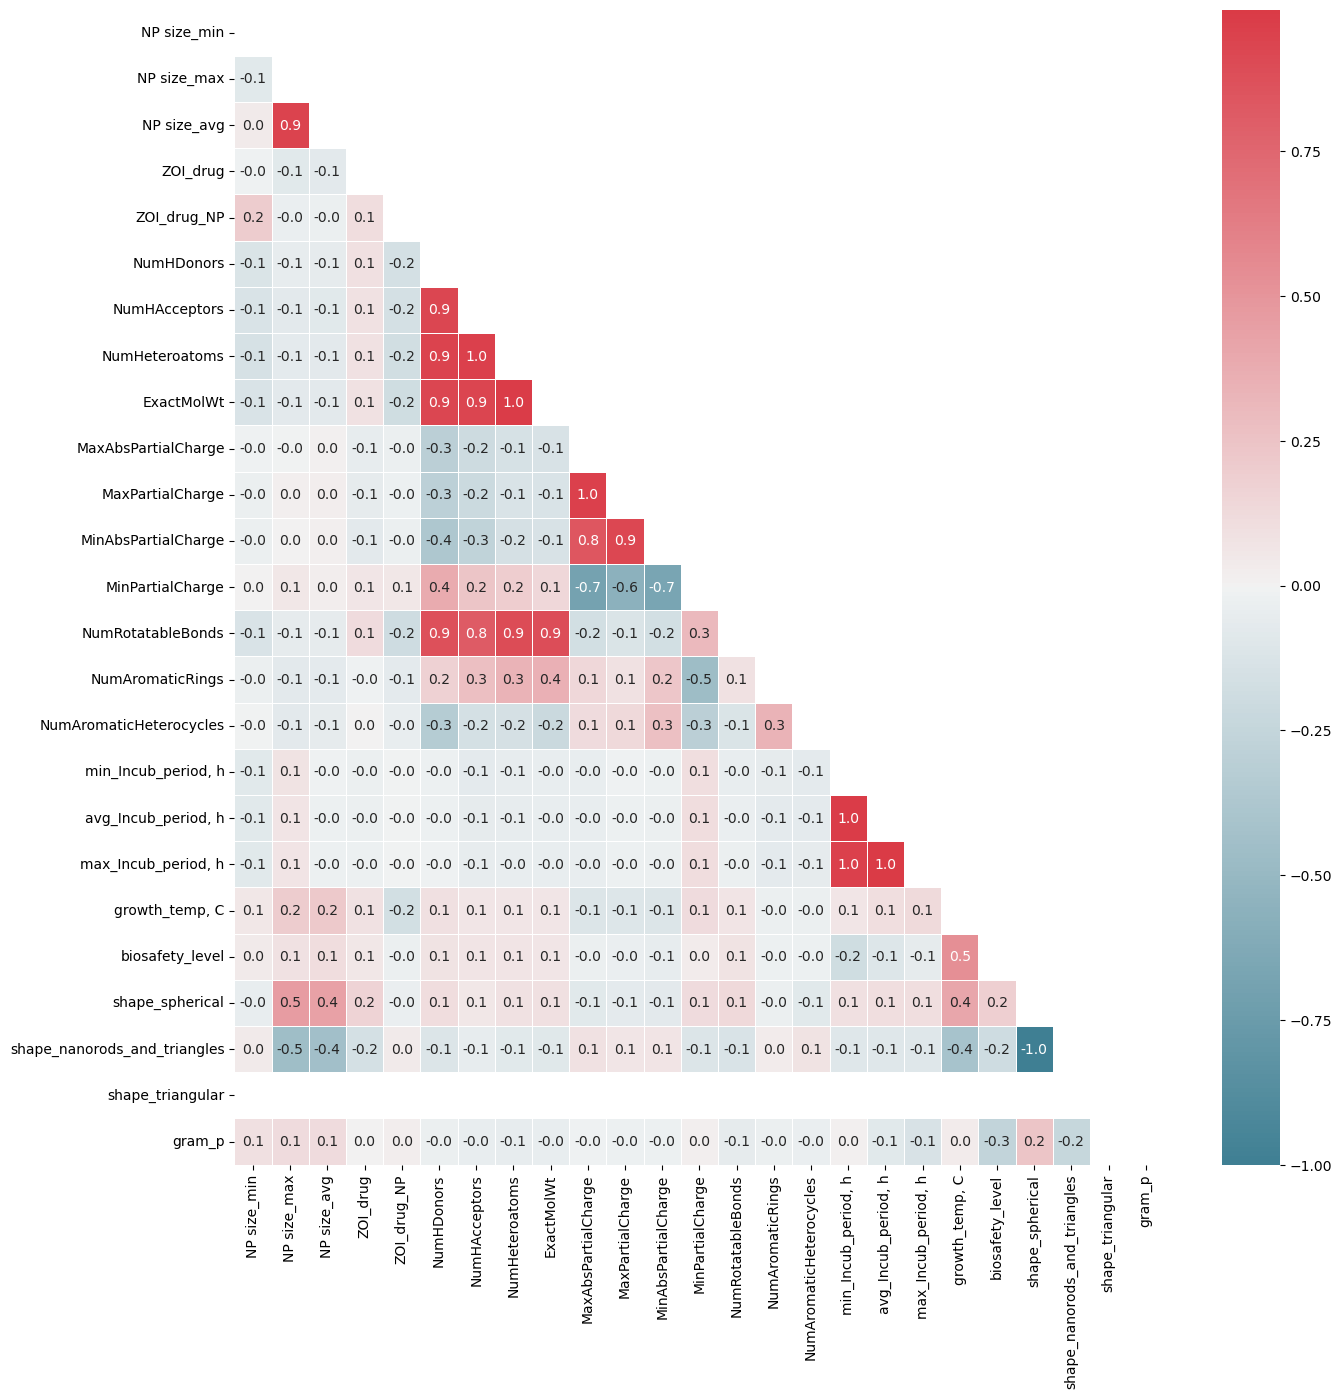

In [13]:
corr1 = df.corr()
mask = np.zeros_like(corr1, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 15)) #создание графика и определение его размеров
cmap = sns.diverging_palette(220, 10, as_cmap=True) #создание палитры для корреляционного графика
sns.heatmap(corr1, cmap=cmap, linewidths=.5, mask=mask, annot=True, fmt=".1f") 
plt.show()

In [14]:
from sklearn import preprocessing

In [15]:
df = df[df['ZOI_drug_NP'] > 0.001]

In [16]:
print(df[df['ZOI_drug']>= 60].shape)
df = df[df['ZOI_drug'] < 60]
df = df[df['ZOI_drug'] >= 0]

(21, 25)


In [17]:
# X = ['NP size_min', 'NP size_max', 'NP size_avg', 'ZOI_drug', 'NumHDonors',
#      'NumHAcceptors', 'MaxAbsPartialCharge','MinAbsPartialCharge', 'MinPartialCharge', 'avg_Incub_period, h','growth_temp, C', 'shape_nanorods_and_triangles','gram_p','biosafety_level']
# y = ['ZOI_drug_NP']
X = ['NP size_min', 'NP size_max', 'NP size_avg', 'ZOI_drug',
       'NumHDonors', 'NumHAcceptors', 'MaxAbsPartialCharge',
       'MinAbsPartialCharge', 'MinPartialCharge', 'NumRotatableBonds',
       'NumAromaticRings', 'NumAromaticHeterocycles', 'min_Incub_period, h',
       'growth_temp, C', 'biosafety_level', 'shape_spherical', 'gram_p']
y = ['ZOI_drug_NP']

In [18]:
train, test = train_test_split(df,random_state=20032003)

In [19]:
X_valid = test[X]
y_valid = test[y]
X_train = train[X]
y_train = train[y]

In [20]:
earlystop_callb = EarlyStopping(monitor='val_mape',
                                patience=32,
                                )
checkpoint_callb = ModelCheckpoint(filepath='model_targ0.h5',
                                   monitor='val_mape',
                                   save_best_only=True)

reducelr_callb = ReduceLROnPlateau(monitor = 'val_mape', 
                                   factor=0.1,
                                   patience=30,
                                   verbose=1)

checkpoint_callb1 = ModelCheckpoint(filepath='model_targ1.h5',
                                   monitor='val_mape',
                                   save_best_only=True)

In [21]:
inp1 = Input(shape=(17,))

x1 = Dense(256, activation='relu')(inp1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dense(64, activation='relu')(x1)
x1 = Dense(1, activation='linear', name='targ0')(x1)

model_one_targ0 = Model(inp1, x1)

model_one_targ0.compile(optimizer=Adam(0.001), loss='mse', metrics=['mape'])

model_one_targ0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 17)]              0         
                                                                 
 dense (Dense)               (None, 256)               4608      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 targ0 (Dense)               (None, 1)                 65        
                                                                 
Total params: 62337 (243.50 KB)
Trainable params: 62337 (243.

In [22]:
history = model_one_targ0.fit(X_train, 
                              y_train, 
                              epochs=1000, 
                              batch_size=16, 
                              validation_data=(X_valid, y_valid),
                              callbacks=[reducelr_callb,
                                         checkpoint_callb,
                                         earlystop_callb
                                         ]
                              )

Epoch 1/1000
24/24 [==============================] - 2s 24ms/step - loss: 120.2482 - mape: 488.0443 - val_loss: 65.2079 - val_mape: 661.3423 - lr: 0.0010
Epoch 2/1000
19/24 [======================>.......] - ETA: 0s - loss: 52.3849 - mape: 342.2572

C:\Users\artda\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 11ms/step - loss: 48.6154 - mape: 308.9771 - val_loss: 55.3400 - val_mape: 542.3980 - lr: 0.0010
Epoch 3/1000
24/24 [==============================] - 0s 8ms/step - loss: 37.3540 - mape: 274.7273 - val_loss: 46.0231 - val_mape: 488.1278 - lr: 0.0010
Epoch 4/1000
24/24 [==============================] - 0s 5ms/step - loss: 32.4272 - mape: 242.9985 - val_loss: 44.5004 - val_mape: 388.3051 - lr: 0.0010
Epoch 5/1000
24/24 [==============================] - 0s 6ms/step - loss: 30.1834 - mape: 209.6142 - val_loss: 45.1928 - val_mape: 363.5424 - lr: 0.0010
Epoch 6/1000
24/24 [==============================] - 0s 5ms/step - loss: 30.2581 - mape: 188.7805 - val_loss: 45.4993 - val_mape: 383.7323 - lr: 0.0010
Epoch 7/1000
24/24 [==============================] - 0s 7ms/step - loss: 27.4195 - mape: 208.1612 - val_loss: 43.2408 - val_mape: 357.8775 - lr: 0.0010
Epoch 8/1000
24/24 [==============================] - 0s 6ms/step - loss: 26.7598 - mape: 168.

In [23]:
model_one_targ0 = load_model('model_targ0.h5')

In [24]:
pred = np.array(model_one_targ0.predict(X_train))
pred1 = np.array(model_one_targ0.predict(X_valid))

5/5 [==============================] - 0s 2ms/step


In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [26]:
print(f"RMSE (train): {np.sqrt(mean_squared_error(y_train, pred))} ")
print(f"RMSE (val): {np.sqrt(mean_squared_error(y_valid, pred1))} ")

RMSE (train): 3.16043560237464 
RMSE (val): 5.687945317472343 


In [27]:
print(f"R2 (train): {np.sqrt(r2_score(y_train, pred))} ")
print(f"R2 (val): {np.sqrt(r2_score(y_valid, pred1))} ")

R2 (train): 0.9439044541986671 
R2 (val): 0.8161094819911845 


In [28]:
import shap
shap.initjs()

In [29]:
train = train.reset_index(drop = True)

In [30]:
train

,NP size_min,NP size_max,NP size_avg,ZOI_drug,ZOI_drug_NP,NumHDonors,NumHAcceptors,NumHeteroatoms,ExactMolWt,MaxAbsPartialCharge,...,NumAromaticHeterocycles,"min_Incub_period, h","avg_Incub_period, h","max_Incub_period, h","growth_temp, C",biosafety_level,shape_spherical,shape_nanorods_and_triangles,shape_triangular,gram_p
0,5.0,32.0,22.5,25.0,25.0,1.0,4.0,5.0,232.084792,0.477497,...,2.0,24.0,36.0,48.0,37.0,2.0,1,0,0,1
1,1.0,9.0,4.7,8.0,4.0,4.0,15.0,18.0,554.046058,0.488304,...,2.0,24.0,36.0,48.0,37.0,2.0,1,0,0,1
2,8.0,20.0,13.5,15.0,15.0,2.0,5.0,7.0,285.067094,0.476538,...,0.0,24.0,48.0,72.0,37.0,2.0,0,1,0,0
3,15.0,30.0,28.0,8.0,2.0,4.0,5.0,8.0,299.093977,0.476539,...,0.0,12.0,18.0,24.0,37.0,2.0,1,0,0,0
4,8.0,20.0,13.5,15.0,15.0,2.0,7.0,7.0,290.137890,0.492704,...,1.0,24.0,36.0,48.0,30.0,1.0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,8.0,20.0,13.5,12.0,12.0,1.0,4.0,5.0,232.084792,0.477497,...,2.0,48.0,84.0,120.0,37.0,2.0,0,1,0,0
380,8.0,20.0,13.5,7.0,8.0,5.0,14.0,14.0,733.461241,0.458937,...,0.0,48.0,84.0,120.0,37.0,2.0,0,1,0,0
381,8.0,20.0,13.5,13.0,13.0,1.0,5.0,8.0,372.054610,1.000000,...,0.0,12.0,42.0,72.0,30.0,2.0,0,1,0,0
382,5.0,40.0,13.0,13.0,16.0,1.0,6.0,9.0,238.033819,0.433062,...,1.0,48.0,84.0,120.0,37.0,2.0,1,0,0,0


In [31]:
train['y_pred'] = model_one_targ0.predict(train[X])

12/12 [==============================] - 0s 2ms/step


In [32]:
train_an = train[['ZOI_drug_NP','y_pred']]
train_an['difference'] = np.sqrt((train_an['ZOI_drug_NP'] - train_an['y_pred'])**2)
train_an.sort_values(by = 'difference',ascending = False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ZOI_drug_NP,y_pred,difference
299,50.00,25.809097,24.190903
167,20.00,1.473988,18.526012
255,31.00,12.652916,18.347084
17,32.00,15.922118,16.077882
142,25.00,10.917691,14.082309
...,...,...,...
372,23.00,23.035433,0.035433
382,16.00,15.965101,0.034899
23,13.00,12.984705,0.015295
238,14.00,13.986592,0.013408


In [33]:
train_an['difference'].median()

1.3277725279331207

In [34]:
train_an

,ZOI_drug_NP,y_pred,difference
0,25.0,24.713083,0.286917
1,4.0,2.836152,1.163848
2,15.0,14.483858,0.516142
3,2.0,0.665549,1.334451
4,15.0,16.020224,1.020224
...,...,...,...
379,12.0,13.053636,1.053636
380,8.0,10.177022,2.177022
381,13.0,13.260615,0.260615
382,16.0,15.965101,0.034899


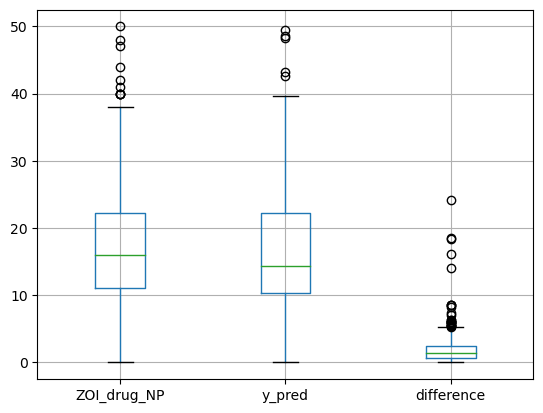

In [35]:
train_an.boxplot()
plt.show()

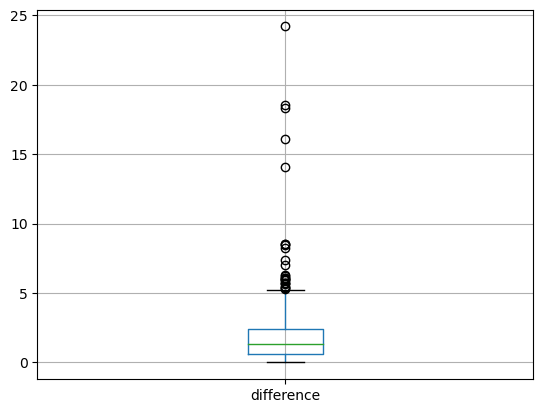

In [36]:
train_an.boxplot('difference')
plt.show()

In [37]:
train_an[train_an['difference']>=5].shape

(26, 3)

In [38]:
shap.initjs()

In [39]:
import keras.backend as K

In [40]:
background = X_train.values[np.random.choice(X_train.shape[0], 100, replace=False)]
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model_one_targ0, X_train.values)
# compute shap values
shap_values = explainer.shap_values(X_train.values)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [41]:
shap_values = shap_values[0]

In [42]:
shap_values.shape

(384, 17)

In [43]:
shap_values[0]

array([-1.10063127e-01, -1.02297324e+00,  1.84839567e+00,  8.80156453e+00,
        1.59553294e-01, -4.40401431e-01,  1.48739900e-03,  4.15394942e-04,
       -1.26075922e-03,  2.63407890e-01,  3.14685324e-01, -1.34732355e+00,
       -2.38354740e-01,  3.61469283e-02,  1.78629116e-02, -1.50611656e-02,
        2.92095336e-01])

In [44]:
X_train

,NP size_min,NP size_max,NP size_avg,ZOI_drug,NumHDonors,NumHAcceptors,MaxAbsPartialCharge,MinAbsPartialCharge,MinPartialCharge,NumRotatableBonds,NumAromaticRings,NumAromaticHeterocycles,"min_Incub_period, h","growth_temp, C",biosafety_level,shape_spherical,gram_p
114,5.0,32.0,22.5,25.0,1.0,4.0,0.477497,0.340725,-0.477497,2.0,2.0,2.0,24.0,37.0,2.0,1,1
478,1.0,9.0,4.7,8.0,4.0,15.0,0.488304,0.352159,-0.488304,8.0,2.0,2.0,24.0,37.0,2.0,1,1
317,8.0,20.0,13.5,15.0,2.0,5.0,0.476538,0.353083,-0.476538,3.0,0.0,0.0,24.0,37.0,2.0,0,0
488,15.0,30.0,28.0,8.0,4.0,5.0,0.476539,0.352951,-0.476539,7.0,0.0,0.0,12.0,37.0,2.0,1,0
308,8.0,20.0,13.5,15.0,2.0,7.0,0.492704,0.221432,-0.492704,5.0,2.0,1.0,24.0,30.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,8.0,20.0,13.5,12.0,1.0,4.0,0.477497,0.340725,-0.477497,2.0,2.0,2.0,48.0,37.0,2.0,0,0
447,8.0,20.0,13.5,7.0,5.0,14.0,0.458937,0.311188,-0.458937,7.0,0.0,0.0,48.0,37.0,2.0,0,0
363,8.0,20.0,13.5,13.0,1.0,5.0,1.000000,0.547832,-0.547832,4.0,1.0,0.0,12.0,30.0,2.0,0,0
270,5.0,40.0,13.0,13.0,1.0,6.0,0.433062,0.399592,-0.399592,3.0,1.0,1.0,48.0,37.0,2.0,1,0


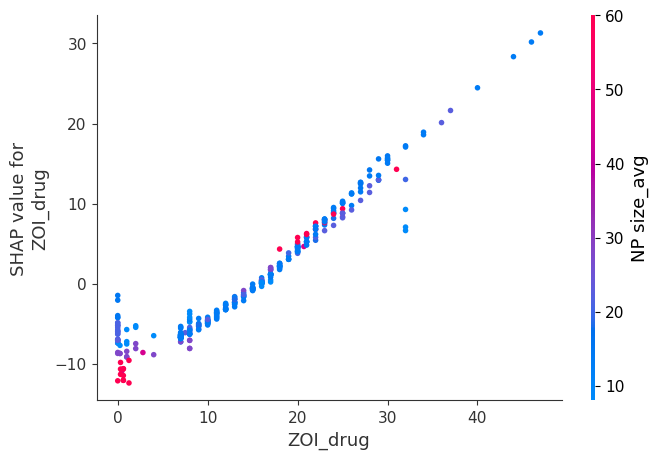

In [45]:
shap.dependence_plot('ZOI_drug', shap_values, X_train)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


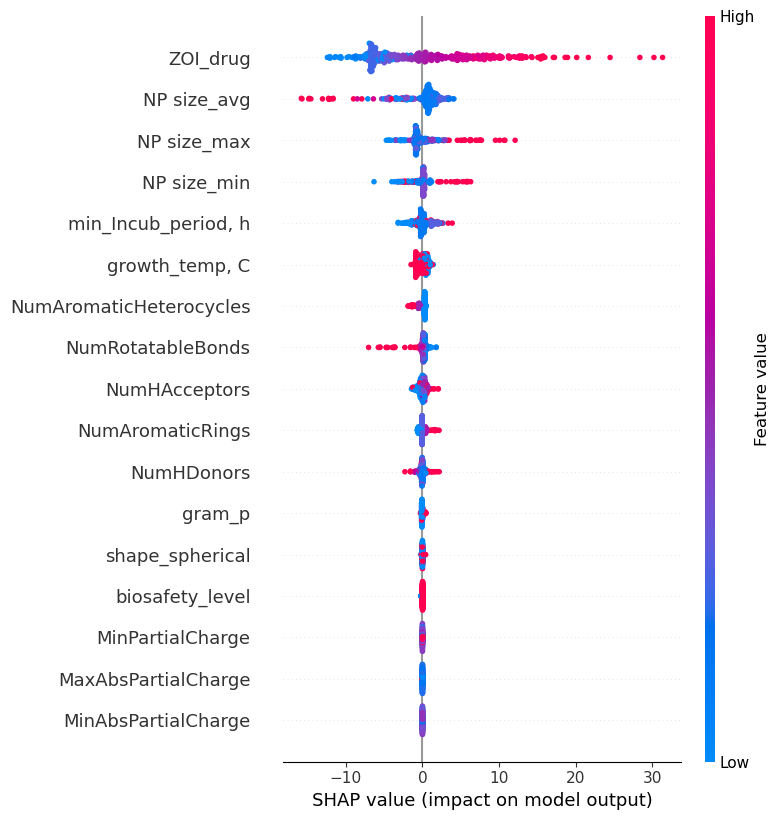

In [46]:
shap.summary_plot(shap_values, X_train)

In [47]:
explainer.expected_value

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([16.152903], dtype=float32)>

In [48]:
expected_value = K.eval(explainer.expected_value[0])
expected_value

16.152903

In [49]:
print('train_an')
print(train_an.iloc[299,:])
shap.force_plot(expected_value, shap_values[0,:], X_train.iloc[299,:])

train_an
ZOI_drug_NP    50.000000
y_pred         25.809097
difference     24.190903
Name: 299, dtype: float64


In [50]:
print('train_an')
print(train_an.iloc[0,:])
shap.force_plot(expected_value, shap_values[0,:], X_train.iloc[0,:])

train_an
ZOI_drug_NP    25.000000
y_pred         24.713083
difference      0.286917
Name: 0, dtype: float64


In [51]:
NUM_ROWS = 5
shap.force_plot(expected_value, shap_values[0:NUM_ROWS], X_train.iloc[0:NUM_ROWS])

In [52]:
feature_names = X_train.columns


rf_resultX = pd.DataFrame(shap_values, columns = feature_names)

vals = np.abs(rf_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
shap_importance

,col_name,feature_importance_vals
3,ZOI_drug,6.122533
2,NP size_avg,1.852607
1,NP size_max,1.301738
0,NP size_min,0.711350
12,"min_Incub_period, h",0.648362
13,"growth_temp, C",0.481390
11,NumAromaticHeterocycles,0.419517
9,NumRotatableBonds,0.414947
5,NumHAcceptors,0.344064
10,NumAromaticRings,0.338851


In [53]:
rf_resultX

,NP size_min,NP size_max,NP size_avg,ZOI_drug,NumHDonors,NumHAcceptors,MaxAbsPartialCharge,MinAbsPartialCharge,MinPartialCharge,NumRotatableBonds,NumAromaticRings,NumAromaticHeterocycles,"min_Incub_period, h","growth_temp, C",biosafety_level,shape_spherical,gram_p
0,-0.110063,-1.022973,1.848396,8.801565,0.159553,-0.440401,0.001487,0.000415,-0.001261,0.263408,0.314685,-1.347324,-0.238355,0.036147,0.017863,-0.015061,0.292095
1,-2.669355,-2.697937,-2.919597,-3.782311,0.055311,0.069674,0.000319,-0.000662,-0.001752,-0.030088,0.318698,-0.657724,-0.338205,-0.627903,0.007146,-0.054894,0.012531
2,0.101642,-0.783598,0.647521,-0.606088,0.122145,-0.280945,0.003259,0.000036,-0.001635,0.296390,-0.497318,0.293697,-0.238742,-0.696257,0.018023,0.013630,-0.060805
3,-2.574435,-0.797863,-3.472628,-7.075624,-0.049367,-0.292879,0.000602,0.000562,-0.000572,-0.132726,-0.509255,0.356591,-1.422144,0.569700,0.010035,0.051967,-0.149319
4,0.176416,-0.674203,1.251982,-0.772524,-0.047383,-0.154661,0.000541,-0.002369,-0.003326,0.197858,0.368148,-0.520936,0.024526,0.271565,-0.136478,-0.011761,-0.100076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,0.090426,-0.847755,0.873203,-3.109586,-0.151747,0.003769,0.001393,0.000323,-0.001404,0.284065,0.308728,-1.305237,1.170482,-0.379048,0.017361,0.001096,-0.055337
380,0.068900,-0.808456,0.879329,-6.721466,-0.069416,0.099439,0.001654,-0.000389,0.001338,0.026864,-0.411637,0.275078,1.117539,-0.402015,0.015261,-0.024837,-0.023068
381,0.136504,-0.759189,1.148043,-2.527529,0.077992,-0.482439,-0.027979,0.004323,-0.010078,0.259072,-0.042787,0.336829,-1.346855,0.451914,0.018556,-0.026564,-0.102101
382,-0.555575,0.695837,0.486361,-1.703270,-0.284578,-0.074867,0.003370,-0.000217,0.008130,0.286082,-0.029397,-0.460923,1.883666,-0.352455,0.016935,-0.040678,-0.066225


In [54]:
X_train[X_train['ZOI_drug']<= 1]

,NP size_min,NP size_max,NP size_avg,ZOI_drug,NumHDonors,NumHAcceptors,MaxAbsPartialCharge,MinAbsPartialCharge,MinPartialCharge,NumRotatableBonds,NumAromaticRings,NumAromaticHeterocycles,"min_Incub_period, h","growth_temp, C",biosafety_level,shape_spherical,gram_p
341,5.00,30.00,21.00,0.0000,3.0,5.0,0.479673,0.327399,-0.479673,4.0,1.0,0.0,24.0,37.0,2.0,1,0
97,14.45,15.55,15.00,0.0000,11.0,15.0,0.393567,0.186623,-0.393567,6.0,0.0,0.0,12.0,37.0,2.0,1,0
512,5.00,80.00,60.00,0.6250,6.0,9.0,0.509651,0.255451,-0.509651,2.0,1.0,0.0,48.0,37.0,2.0,1,0
522,15.00,30.00,28.00,0.2500,8.0,12.0,0.387562,0.185232,-0.387562,7.0,0.0,0.0,24.0,37.0,2.0,1,1
532,4.00,10.00,8.00,0.0300,8.0,12.0,0.387562,0.185232,-0.387562,7.0,0.0,0.0,24.0,37.0,2.0,1,1
41,14.45,15.55,15.00,0.0000,6.0,9.0,0.509649,0.255451,-0.509649,2.0,1.0,0.0,48.0,37.0,2.0,1,0
35,14.45,15.55,15.00,0.0000,2.0,5.0,0.477497,0.340723,-0.477497,3.0,2.0,1.0,12.0,37.0,2.0,1,0
518,5.00,80.00,60.00,0.6250,1.0,5.0,1.000000,0.547832,-0.547832,4.0,1.0,0.0,48.0,37.0,2.0,1,0
530,4.00,10.00,8.00,1.0000,4.0,6.0,0.507967,0.327399,-0.507967,4.0,1.0,0.0,24.0,37.0,2.0,1,1
523,4.00,10.00,8.00,1.0000,8.0,12.0,0.387562,0.185232,-0.387562,7.0,0.0,0.0,24.0,37.0,2.0,1,1
